In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install opencv-python-headless==4.1.2.30
!pip install -U albumentations
!pip install wandb
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install torchsummary

In [ ]:
from collections import defaultdict, namedtuple
from itertools import product
import numpy as np
import pandas as pd
import cv2
import os
import wandb
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchmetrics import MeanMetric
import torchmetrics.functional as metrics
import torchvision.models as models

In [ ]:
%env WANDB_SILENT=True
wandb.login()

env: WANDB_SILENT=True


True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Read data

In [ ]:
PROJECT_NAME = 'CracksNewLength'

TRAIN_X_1 = Path('/content/drive/MyDrive/Data/CracksNew/02-04-22_1024-1024_train_images1.csv')
TRAIN_Y_1 = Path('/content/drive/MyDrive/Data/CracksNew/02-04-22_1024-1024_train_labels1.csv')
TRAIN_X_2 = Path('/content/drive/MyDrive/Data/CracksNew/02-04-22_1024-1024_train_images2.csv')
TRAIN_Y_2 = Path('/content/drive/MyDrive/Data/CracksNew/02-04-22_1024-1024_train_labels2.csv')
TRAIN_X_3 = Path('/content/drive/MyDrive/Data/CracksNew/02-04-22_1024-1024_train_images3.csv')
TRAIN_Y_3 = Path('/content/drive/MyDrive/Data/CracksNew/02-04-22_1024-1024_train_labels3.csv')
TRAIN_X_4 = Path('/content/drive/MyDrive/Data/CracksNew/02-04-22_1024-1024_train_images4.csv')
TRAIN_Y_4 = Path('/content/drive/MyDrive/Data/CracksNew/02-04-22_1024-1024_train_labels4.csv')
TRAIN_X_1_1 = Path('/content/drive/MyDrive/Data/CracksNew/07-04-22_1024-1024_train_images360.csv')
TRAIN_Y_1_1 = Path('/content/drive/MyDrive/Data/CracksNew/07-04-22_1024-1024_train_labels360.csv')

TRAIN_X_1_2 = Path('/content/drive/MyDrive/Data/CracksNew/07-04-22_1024-1024_train_images540.csv')
TRAIN_Y_1_2 = Path('/content/drive/MyDrive/Data/CracksNew/07-04-22_1024-1024_train_labels540.csv')

TRAIN_X_1_3 = Path('/content/drive/MyDrive/Data/CracksNew/07-04-22_1024-1024_train_images720.csv')
TRAIN_Y_1_3 = Path('/content/drive/MyDrive/Data/CracksNew/07-04-22_1024-1024_train_labels720.csv')

TEST_X = Path('/content/drive/MyDrive/Data/CracksNew/images_test_512_512.csv')
TEST_Y = Path('/content/drive/MyDrive/Data/CracksNew/labels_test_512_512.csv')

TEST_X_20 = Path('/content/drive/MyDrive/Data/CracksNew/07-04-22_1024-1024_train_images20.csv')
TEST_Y_20 = Path('/content/drive/MyDrive/Data/CracksNew/07-04-22_1024-1024_train_labels20.csv')

TRAIN_LENGTH_X_2a = Path('/content/drive/MyDrive/Data/CracksNew/20-04-22_1024-1024_train_images_2a.csv')
TRAIN_LENGTH_Y_2a = Path('/content/drive/MyDrive/Data/CracksNew/20-04-22_1024-1024_train_length_2a.csv')

TEST_LENGTH_X_2a = Path('/content/drive/MyDrive/Data/CracksNew/20-04-22_1024-1024_test_images_2a.csv')
TEST_LENGTH_Y_2a = Path('/content/drive/MyDrive/Data/CracksNew/20-04-22_1024-1024_test_length_2a.csv')

TRAIN_LENGTH_X_2b = Path('/content/drive/MyDrive/Data/CracksNew/20-04-22_1024-1024_train_images_2b.csv')
TRAIN_LENGTH_Y_2b = Path('/content/drive/MyDrive/Data/CracksNew/20-04-22_1024-1024_train_length_2b.csv')

TEST_LENGTH_X_2b = Path('/content/drive/MyDrive/Data/CracksNew/20-04-22_1024-1024_test_images_2b.csv')
TEST_LENGTH_Y_2b = Path('/content/drive/MyDrive/Data/CracksNew/20-04-22_1024-1024_test_length_2b.csv')

TRAIN_IMAGES_X_3_1 = Path('/content/drive/MyDrive/Data/CracksNew/GeneralExperiment/21-05-22_1km-1km_train_images_4.csv')
TRAIN_LENGTH_Y_3_1 = Path('/content/drive/MyDrive/Data/CracksNew/GeneralExperiment/21-05-22_1km-1km_train_length_4.csv')
TRAIN_ALPHA_Y_3_1 = Path('/content/drive/MyDrive/Data/CracksNew/GeneralExperiment/21-05-22_1km-1km_train_alpha_4.csv')

TRAIN_IMAGES_X_3_2 = Path('/content/drive/MyDrive/Data/CracksNew/GeneralExperiment/21-05-22_1km-1km_train_images_5.csv')
TRAIN_LENGTH_Y_3_2 = Path('/content/drive/MyDrive/Data/CracksNew/GeneralExperiment/21-05-22_1km-1km_train_length_5.csv')
TRAIN_ALPHA_Y_3_2 = Path('/content/drive/MyDrive/Data/CracksNew/GeneralExperiment/21-05-22_1km-1km_train_alpha_5.csv')

TEST_IMAGES_X_3 = Path('/content/drive/MyDrive/Data/CracksNew/GeneralExperiment/22-05-22_1km-1km_test_images_1.csv')
TEST_LENGTH_Y_3 = Path('/content/drive/MyDrive/Data/CracksNew/GeneralExperiment/22-05-22_1km-1km_test_length_1.csv')
TEST_ALPHA_Y_3 = Path('/content/drive/MyDrive/Data/CracksNew/GeneralExperiment/22-05-22_1km-1km_test_alpha_1.csv')

CHECKPOINTS_FOLDER = Path(f'/content/drive/MyDrive/Checkpoints/{PROJECT_NAME}/')
CHECKPOINTS_FOLDER.mkdir(parents=True, exist_ok=True)

## Parse data


#### Data analyse

In [ ]:
def show_images(
    data,
    show_mask=False,
    show_separate=False,
    titles=None,
    n_max=5,
    shuffle=False,
    size=4,
    n_cols=5,
    cmap='viridis'
):
    images = data
    
    to_show = min(len(images), n_max)
    n_rows = to_show // n_cols + 1
    indicies = np.arange(len(images))

    if shuffle:
        np.random.shuffle(indicies)

    plt.figure(figsize=(size * n_cols, size * n_rows))
    
    for i, j in enumerate(indicies[:to_show]):
        
        if images[j].shape[0] == 3:
            image = images[j].permute(1, 2, 0)
        elif images[j].shape[0] == 1:
            image = images[j].squeeze()
        else:
            image = images[j]

        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
        
        if titles is not None:
            plt.title(titles[j])

#### Dataset

In [ ]:
angle_classes_map = np.arange(0, 180)
length_classes_map = np.arange(100, 300, 2)

In [ ]:
# Описание своего датасета и наследование от стандартного 'Dataset' из pytorch
# self - стандартный атрибут, он указывается у всех функций в классе
class CracksDataset(Dataset):
    # Инициализация: folder - папка с картинками и лейблами, в transform передаются ауги 
    def __init__(self, images_paths, labels_paths, transform, classes_map):
        # Чтение изображений и лейблов
        raw_images = list()
        raw_labels = list()
        for images_path, labels_path in zip(images_paths, labels_paths):
          with open(images_path) as f:
            raw_images.extend(f.readlines())
          with open(labels_path) as f:
            raw_labels.extend(f.readlines())

        # Шаг между значениями в классах
        step = classes_map[1] - classes_map[0]

        # Создание списков данных
        self.images = list()
        self.labels = list()
        for raw_image, raw_label in zip(raw_images, raw_labels):
          image = raw_image.split(',')
          image = list(map(float, image))
          side = int(np.sqrt(len(image)))
          image = np.array(image).reshape(side, side)
          image = transform(image=image)['image']
          label = int(raw_label) // step * step
          label = np.where(classes_map == label)[0][0]
          self.images.append(image)
          self.labels.append(label)

    # Получение длины датасета
    def __len__(self):
        return len(self.images)

    # Получение конкретной картинки и маски по индексу
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

#### Augmentation & Visalize

In [ ]:
train_transform = A.Compose([
    A.FromFloat(dtype=np.float32, max_value=1.0),
    A.Resize(height=224, width=224, interpolation=0),
    # A.RandomCrop(width=224, height=224),
    # A.CoarseDropout(p=0.5, min_holes=5, max_holes=5, min_height=8, min_width=8, max_height=16, max_width=16),
    ToTensorV2()
])

In [ ]:
# Создание датасета
train_dataset = CracksDataset(
    images_paths=[TRAIN_IMAGES_X_3_1, TRAIN_IMAGES_X_3_2],
    labels_paths=[TRAIN_LENGTH_Y_3_1, TRAIN_LENGTH_Y_3_2],
    transform=train_transform,
    classes_map=length_classes_map
)

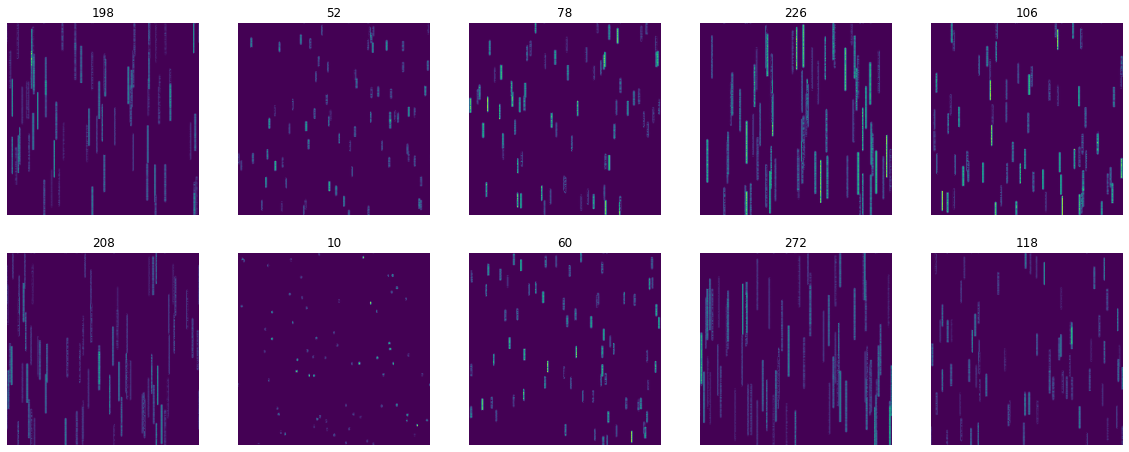

In [ ]:
# Создание DataLoader - для подгрузки данных по батчам
example_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset))

# Получить первый батч из DataLoader (просто запомнить)
images, labels = next(iter(example_loader))

# Лэйблы
titles = [length_classes_map[l.item()] for l in labels]

show_images(images, titles=titles, shuffle=True, n_max=10)

#### Split train/validation

In [ ]:
data_size = len(train_dataset)
val_split_i = int(data_size * 0.2)
data_indices = list(range(data_size))
np.random.shuffle(data_indices)

val_indices = data_indices[:val_split_i]
train_indices = data_indices[val_split_i:]

len(val_indices), len(train_indices)

(29, 116)

## Train

In [ ]:
def train_model(
    train_loader,
    val_loader,
    model,
    criterion,
    metric,
    optimizer,
    scheduler=None,
    epochs=5,
    run_name='main',
    log=False,
    silent_mode=False,
    metric_treshhold=0.0
):
    if log:
        wandb.init(project=PROJECT_NAME)

    loss_meter, metric_meter = MeanMetric(), MeanMetric()
    best_loss, best_metric = float('inf'), 0

    for epoch in tqdm(range(1, epochs + 1), disable=silent_mode):
        # Train
        loss_meter.reset()
        metric_meter.reset()
        model.train()
        for X, y in train_loader:
            X_gpu = X.to(device)
            y_gpu = y.to(device)
            prediction = model(X_gpu)
            loss_value = criterion(prediction, y_gpu)
            metric_value = metric(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            loss_meter.update(loss_value.item())
            metric_meter.update(metric_value.item())
        
        train_loss, train_metric = loss_meter.compute(), metric_meter.compute()
        
        # Validation
        loss_meter.reset()
        metric_meter.reset()
        model.eval()
        with torch.no_grad():
            for X, y in val_loader:
                X_gpu = X.to(device)
                y_gpu = y.to(device)
                prediction = model(X_gpu)
                loss_value = criterion(prediction, y_gpu)
                metric_value = metric(prediction, y_gpu)
                loss_meter.update(loss_value.item())
                metric_meter.update(metric_value.item())
        
        val_loss, val_metric = loss_meter.compute(), metric_meter.compute()

        # Learning rate annealing
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
            else:
                scheduler.step()

        # Log
        if not silent_mode:
            print(f'epoch: {epoch:<3}', end=' | ') 
            print(f'train_loss: {train_loss:.5f}', end=' | ')
            print(f'train_metric: {train_metric:.3f}', end=' | ')
            print(f'val_loss: {val_loss:.5f}', end=' | ')
            print(f'val_metric: {val_metric:.3f}')
        if log:
            wandb.log({
                'train_loss': train_loss,
                'train_metric': train_metric,
                'val_loss': val_loss,
                'val_metric': val_metric
            }, step=epoch)

        # Saving model checkpoint
        if val_metric > best_metric:
            best_loss = val_loss
            best_metric = val_metric
            torch.save(model, os.path.join(CHECKPOINTS_FOLDER, f'{run_name}.pt'))
        
        # Exiting if metric is low
        if val_metric < metric_treshhold:
            break
    
    if log:
        wandb.finish()

    if not silent_mode:
        print(f'\nbest_loss: {best_loss:.5f}, best_metric: {best_metric:.3f}')
    else:
        return best_loss.item(), best_metric.item()

In [ ]:
def get_best_model(checkpoints_folder, run_name):
    return torch.load(os.path.join(checkpoints_folder, f'{run_name}.pt'))

## Metrics


In [ ]:
class Accuracy(nn.Module):
    def __init__(self, threshold=5, smooth=1e-15):
        super().__init__()
        self.threshold = threshold
        self.smooth = smooth
    
    def forward(self, preds, outputs):
        
        _, preds = torch.max(preds, 1)

        mod_of_diff = abs(preds - outputs)
        true_preds_1 = mod_of_diff < self.threshold
        true_preds_2 = -mod_of_diff + 180 < self.threshold

        accuracy = (true_preds_1.sum() + true_preds_2.sum()) / preds.shape[0]

        return accuracy

## Model, loss & optimizer

#### Models for angles


In [ ]:
batch_size = 50

angle_train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_indices)
)

angle_val_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_indices)
)

In [ ]:
angle_model_1 = models.resnet50(pretrained=True)
angle_model_1.conv1 = nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)

for parameter in angle_model_1.parameters():
    parameter.requires_grad = False

classes_n = angle_classes_map.shape[0]
angle_model_1.fc = nn.Linear(angle_model_1.fc.in_features, classes_n)

angle_model_1.to(device)

criterion = nn.CrossEntropyLoss()
metric = Accuracy()
optimizer = optim.Adam(angle_model_1.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold=1e-3, verbose=True)

In [ ]:
train_model(angle_train_loader, angle_val_loader, angle_model_1, criterion, metric, optimizer, scheduler, epochs=100, run_name='Try-1.3', log=True)

### Models for length


In [ ]:
batch_size = 10

length_train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_indices)
)

length_val_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_indices)
)

In [ ]:
length_model_1 = models.resnet50(pretrained=True)
length_model_1.conv1 = nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)

for parameter in length_model_1.parameters():
    parameter.requires_grad = False

classes_n = length_classes_map.shape[0]
length_model_1.fc = nn.Linear(length_model_1.fc.in_features, classes_n)

length_model_1.to(device)

criterion = nn.CrossEntropyLoss()
metric = Accuracy()
optimizer = optim.Adam(length_model_1.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold=1e-3, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
train_model(length_train_loader, length_val_loader, length_model_1, criterion, metric, optimizer, scheduler, epochs=50, run_name='Try-Length-2b', log=True)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 1   | train_loss: 7.46299 | train_metric: 0.067 | val_loss: 7.13228 | val_metric: 0.104
epoch: 2   | train_loss: 5.12429 | train_metric: 0.156 | val_loss: 8.46393 | val_metric: 0.000
epoch: 3   | train_loss: 4.37894 | train_metric: 0.161 | val_loss: 7.47737 | val_metric: 0.037
epoch: 4   | train_loss: 3.55122 | train_metric: 0.567 | val_loss: 6.80642 | val_metric: 0.000
epoch: 5   | train_loss: 3.08695 | train_metric: 0.631 | val_loss: 6.91961 | val_metric: 0.141
epoch: 6   | train_loss: 2.52232 | train_metric: 0.883 | val_loss: 7.25618 | val_metric: 0.174
epoch: 7   | train_loss: 2.21071 | train_metric: 0.881 | val_loss: 7.56797 | val_metric: 0.100
epoch: 8   | train_loss: 1.77134 | train_metric: 0.975 | val_loss: 8.00013 | val_metric: 0.070
epoch: 9   | train_loss: 1.44480 | train_metric: 1.000 | val_loss: 8.17982 | val_metric: 0.237
epoch: 10  | train_loss: 1.24521 | train_metric: 0.983 | val_loss: 8.06934 | val_metric: 0.100
epoch: 11  | train_loss: 0.94093 | train_metric: 0

## Predict

In [ ]:
def evaluate_model(loader, model):

    X = list()
    y = list()
    for X_batch, y_batch in loader:
      X.extend(X_batch)
      y.extend(y_batch)
    
    # cat - это операция объединения тензоров
    # Был shape (36, 224, 224) -> стал (36, 1, 224, 224), это всё unsqeeze
    X = torch.cat(X).unsqueeze(1)
    y = torch.tensor(y)

    model.eval()
    with torch.no_grad():
        X_gpu = X.to(device)
        preds = model(X_gpu)
    
    return X, y, preds.cpu()

In [ ]:
test_dataset = CracksDataset(
    images_paths=[TEST_LENGTH_X_2b],
    labels_paths=[TEST_LENGTH_Y_2b],
    transform=train_transform,
    classes_map=length_classes_map
)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [ ]:
best_model = get_best_model(CHECKPOINTS_FOLDER, 'Try-Length-2b')

In [ ]:
inputs, outputs, preds = evaluate_model(test_loader, best_model)

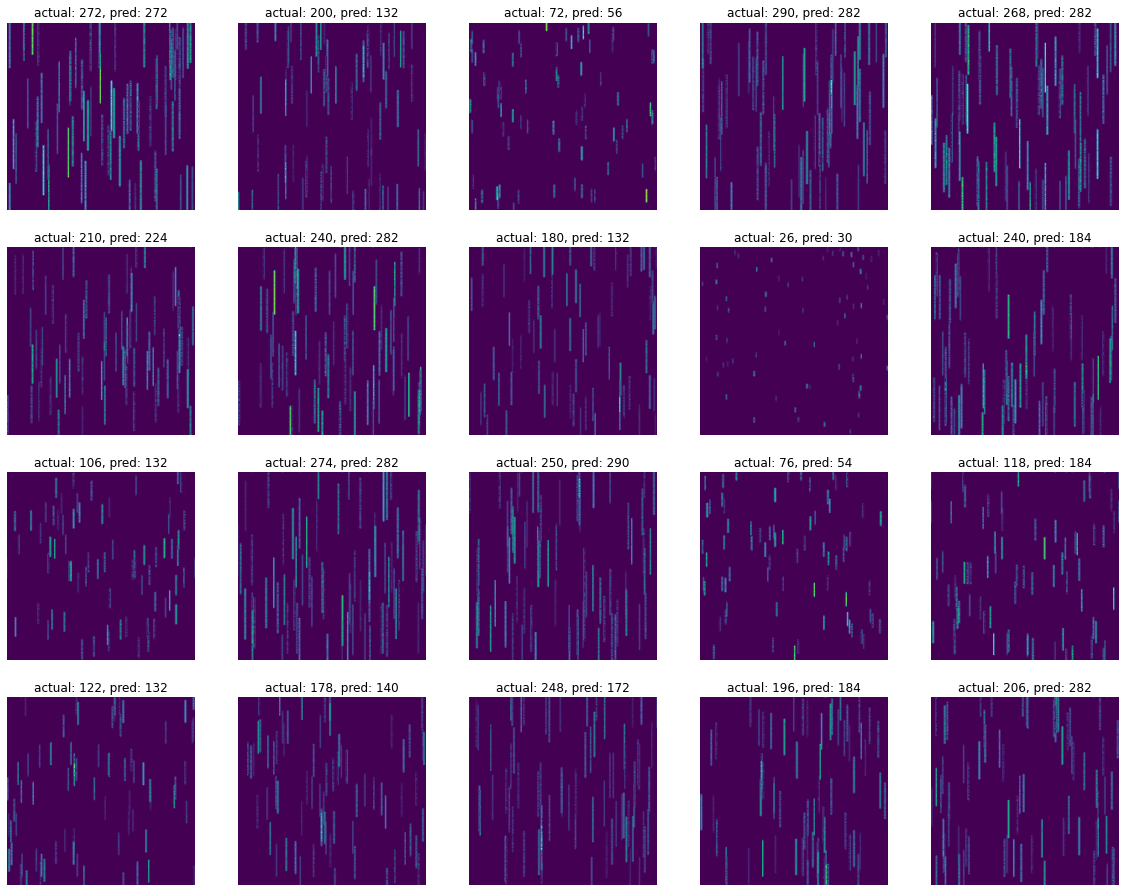

In [ ]:
_, preds_target = torch.max(preds, 1)

titles = []
for actual_i, pred_i in zip(outputs, preds_target):
  actual = length_classes_map[actual_i]
  pred = length_classes_map[pred_i]
  titles.append(f'actual: {actual}, pred: {pred}')

show_images(inputs, titles=titles, shuffle=True, n_max=20)

In [ ]:
Accuracy()(preds, outputs).item()

0.20000000298023224

In [ ]:
Accuracy(10)(preds, outputs).item()

0.44999998807907104

In [ ]:
Accuracy(2)(preds, outputs).item()

0.05000000074505806